# `Preprocessing workflow`

#### The preprocessing workflow consists of nine steps:

![Preprocessing.png](images/Preprocessing.png)

##### - `Optional step: Convert Thermo files (*.raw):`

ThermoRawFileParser https://github.com/compomics/ThermoRawFileParser

- It is necessary to convert profile data to centroid mzml. If your files do not originate from a thermo instrument, please convert them using proteowizard (see https://proteowizard.sourceforge.io/) and add them to the "data/mzML/" directory. 

In [1]:
!mono resources/ThermoRawFileParser/ThermoRawFileParser.exe -d="data/raw/" -o="data/mzML/"

2022-03-06 10:02:11 INFO Started analyzing folder data/raw/
2022-03-06 10:02:11 INFO The folder contains 3 RAW files
2022-03-06 10:02:11 INFO Started parsing data/raw/20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.raw
2022-03-06 10:02:12 INFO Processing 5470 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2022-03-06 10:02:21 INFO Finished parsing data/raw/20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.raw
2022-03-06 10:02:21 INFO Started parsing data/raw/20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.raw
2022-03-06 10:02:22 INFO Processing 5572 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2022-03-06 10:02:30 INFO Finished parsing data/raw/20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.raw
2022-03-06 10:02:30 INFO Started parsing data/raw/20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.raw
2022-03-06 10:02:30 INFO Processing 5236 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2022-03-06 10:02:39 INFO Finished parsing data/raw/20210827_UMETAB219

Import libraries:

In [13]:
import os
import glob
import sys
import pandas as pd
from pyopenms import *

#### `1) PrecursorCorrection` (To the "highest intensity MS1 peak")

This algorithm is used directly after the file introduction, in order to correct any wrong MS1 precursor annotation. For each MS2 spectrum the corresponding MS1 spectrum is determined by using the RT information of the precursor. In the MS1 spectrum, the highest intensity peak is selected as the corrected precursor. We assume that, in a given mass window  (e.g. precursor mass +/- 10 ppm), the precursor with the hightest intensity was actually fragmented (top-n method), which is a method used in the Thermo Orbitrap instrument (Center for Biosustainability).


###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html//classOpenMS_1_1PrecursorCorrection.html#a8acf85ba8b9f249de0369bb083355982 
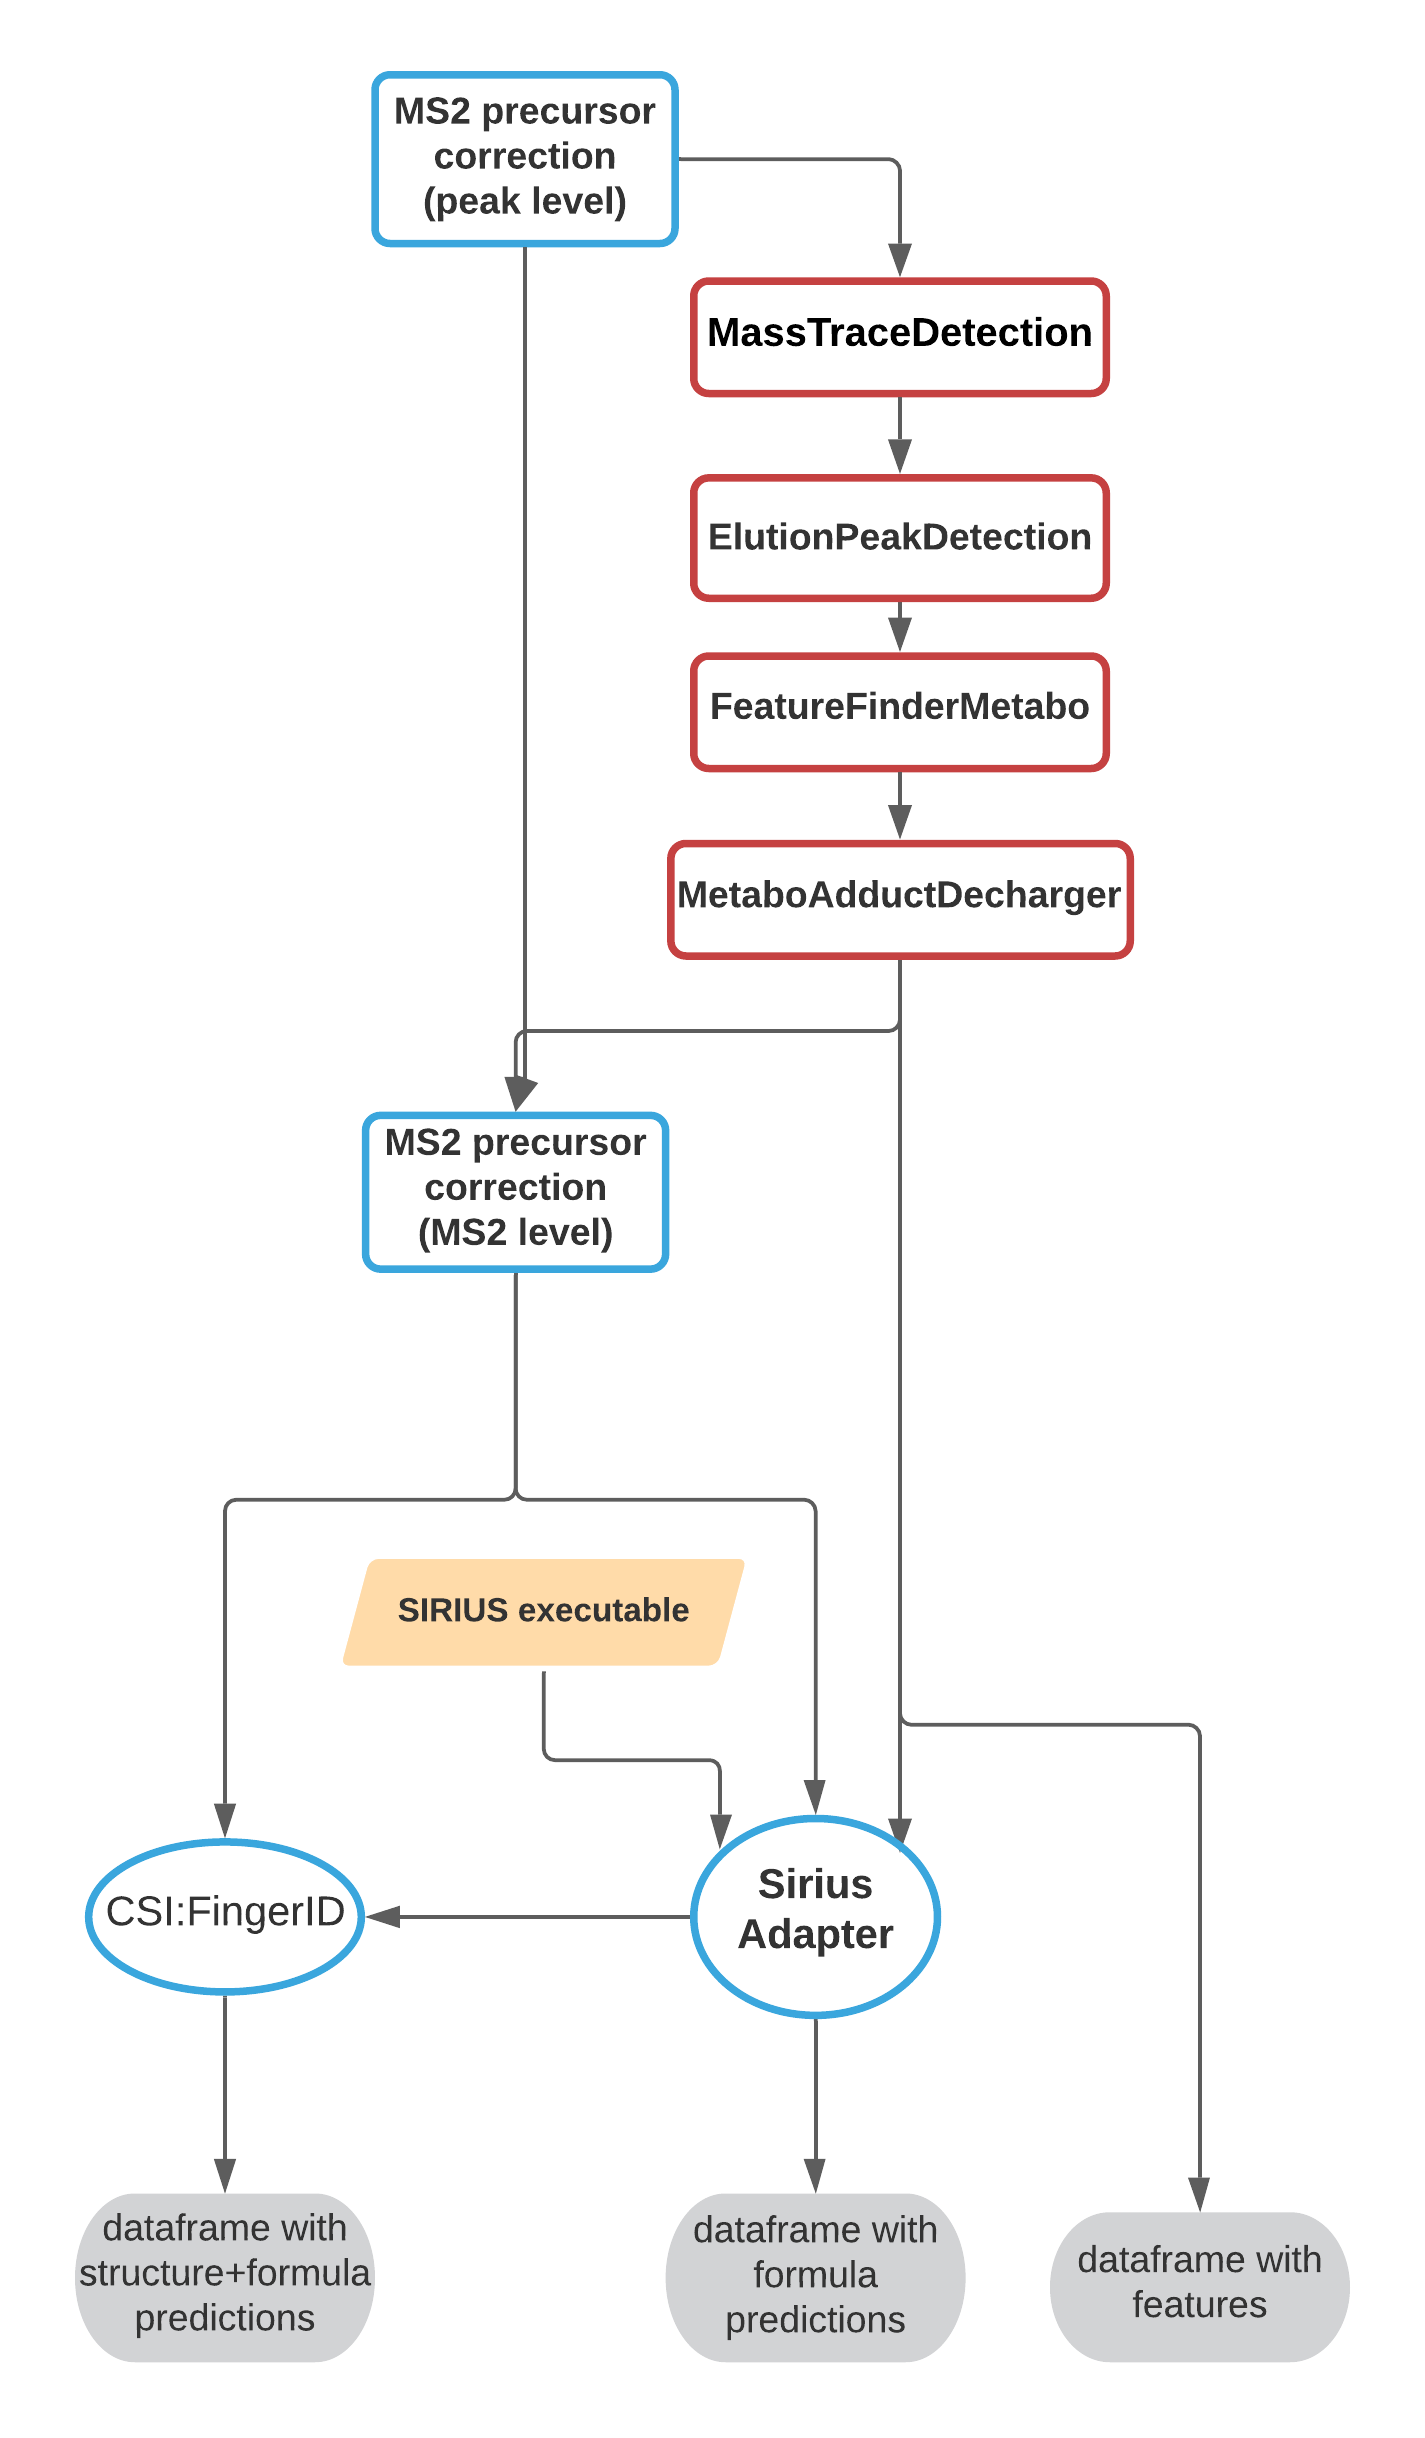

In [14]:
path= "results/interim/mzML"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_original_files = glob.glob('data/mzML/*.mzML')
    
for filename in input_original_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    delta_mzs= []
    mzs = []
    rts= []
    PrecursorCorrection.correctToHighestIntensityMS1Peak(exp, 100.0, True, delta_mzs, mzs, rts)
    mzmlfile_path = os.path.join(path, 'PCpeak_' + os.path.basename(filename))
    MzMLFile().store(mzmlfile_path, exp)

Correction to the highest intensity peak failed 1 times because of missing peaks in the MS1. No changes were applied in these cases.
5471 spectra and 1 chromatograms stored.
5547 spectra and 1 chromatograms stored.
Correction to the highest intensity peak failed 1 times because of missing peaks in the MS1. No changes were applied in these cases.
5572 spectra and 1 chromatograms stored.
5402 spectra and 1 chromatograms stored.
5476 spectra and 1 chromatograms stored.
5682 spectra and 1 chromatograms stored.
4857 spectra and 1 chromatograms stored.
5236 spectra and 1 chromatograms stored.
5470 spectra and 1 chromatograms stored.
5610 spectra and 1 chromatograms stored.
5587 spectra and 1 chromatograms stored.
Correction to the highest intensity peak failed 1 times because of missing peaks in the MS1. No changes were applied in these cases.


#### `2) Mass trace detection`

A mass trace extraction method that gathers peaks similar in m/z and moving along retention time.
Peaks of a MSExperiment are sorted by their intensity and stored in a list of potential chromatographic apex positions. Only peaks that are above the noise threshold (user-defined) are analyzed and only peaks that are n times above this minimal threshold are considered as apices. This saves computational resources and decreases the noise in the resulting output.
Starting with these, mass traces are extended in- and decreasingly in retention time. During this extension phase, the centroid m/z is computed on-line as an intensity-weighted mean of peaks.
The extension phase ends when either the frequency of gathered peaks drops below a threshold (min_sample_rate, see MassTraceDetection parameters) or when the number of missed scans exceeds a threshold (trace_termination_outliers, see MassTraceDetection parameters).
Finally, only mass traces that pass a filter (a certain minimal and maximal length as well as having the minimal sample rate criterion fulfilled) get added to the result.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MassTraceDetection.html#abff6e392ce6da7af8f083397494a7971



#### `3) Elution peak detection`

Extracts chromatographic peaks from a mass trace.
Mass traces may consist of several consecutively (partly overlapping) eluting peaks, e.g., stemming from (almost) isobaric compounds that are separated by retention time. Especially in metabolomics, isomeric compounds with exactly the same mass but different retentional behaviour may still be contained in the same mass trace. This method first applies smoothing on the mass trace's intensities, then detects local minima/maxima in order to separate the chromatographic peaks from each other. Depending on the "width_filtering" parameters, mass traces are filtered by length in seconds ("fixed" filter) or by quantile.

This method is in other words "deconvolution".

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1ElutionPeakDetection.htmldetails


#### `4) Feature detection`

FeatureFinderMetabo assembles metabolite features from singleton mass traces.
Mass traces alone would allow for further analysis such as metabolite ID or statistical evaluation. However, in general, monoisotopic mass traces are accompanied by satellite C13 peaks and thus may render the analysis more difficult. FeatureFinderMetabo fulfills a further data reduction step by assembling compatible mass traces to metabolite features (that is, all mass traces originating from one metabolite). To this end, multiple metabolite hypotheses are formulated and scored according to how well differences in RT (optional), m/z or intensity ratios match to those of theoretical isotope patterns.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1FeatureFindingMetabo.html

#### `5) Metabolite adduct decharger` 

For each peak, this algorithm reconstructs neutral masses by enumerating all possible adducts with matching charge. You can add the list of adduct files and database files for the algorithm to parse through.
With SIRIUS, an algorithm that is later used, you are only able to use singly charged adducts so charges higher than 1 are filtered out. 

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_MetaboliteAdductDecharger.html

In [15]:
path= "results/interim/preprocess"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_mzml_files = glob.glob('results/interim/mzML/PCpeak_*.mzML')

# 2) Mass trace detection

for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    mass_traces = []
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults()
    mtd_par.setValue("mass_error_ppm", 10.0) 
    mtd_par.setValue("noise_threshold_int", 1.0e04)
    mtd.setParameters(mtd_par)
    mtd.run(exp, mass_traces, 0)

# 3) Elution peak detection

    mass_traces_split = []
    mass_traces_final = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed")
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_split)
     
    if (epd.getParameters().getValue("width_filtering") == "auto"):
          epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
    else:
          mass_traces_final = mass_traces_split

# 4) Feature finding metabo
  
    feature_map_FFM = FeatureMap()
    feat_chrom = []
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("isotope_filtering_model", "none")
    ffm_par.setValue("remove_single_traces", "true")
    ffm_par.setValue("mz_scoring_by_elements", "false")
    ffm_par.setValue("report_convex_hulls", "true")
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_final, feature_map_FFM, feat_chrom)
    feature_map_FFM.setUniqueIds()
    feature_map_FFM.setPrimaryMSRunPath([filename.encode()])  


# 5) Metabolite adduct decharger (MetaboliteFeatureDeconvolution)

    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts", [b"H:+:0.4",b"Na:+:0.2",b"NH4:+:0.2", b"H-1O-1:+:0.1", b"H-3O-2:+:0.1"])
    mdf_par.setValue("charge_min", 1, "Minimal possible charge")
    mdf_par.setValue("charge_max", 1, "Maximal possible charge")
    mdf_par.setValue("charge_span_max", 1)
    mdf_par.setValue("max_neutrals", 1)
    mfd.setParameters(mdf_par)
        
    feature_map_MFD = FeatureMap()
    cons_map0 = ConsensusMap()
    cons_map1 = ConsensusMap()
    mfd.compute(feature_map_FFM, feature_map_MFD, cons_map0, cons_map1)
    consensusfile = os.path.join(path, 'MFD_' + os.path.basename(filename)[7:-5] +".consensusXML")
    ConsensusXMLFile().store(consensusfile, cons_map0)
    featurefile = os.path.join(path, 'MFD_' + os.path.basename(filename)[7:-5] +".featureXML")
    FeatureXMLFile().store(featurefile, feature_map_MFD)

Progress of 'mass trace detection':
-- done [took 0.32 s (CPU), 0.41 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.75 s (CPU), 0.78 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 1.06 s (CPU), 1.08 s (Wall)] -- 
MassExplainer table size: 20
5591 spectra and 1 chromatograms stored.
Generating Masses with threshold: -6.90776 ...
done
0 of 65 valid net charge compomer results did not pass the feature charge constraints
Inferring edges raised edge count from 77 to 77
Found 77 putative edges (of 977) and avg hit-size of 1
Using solver 'coinor' ...
Optimal solution found!
 Branch and cut took 0.019729 seconds,  with objective value: 2.98.
ILP score is: 2.98
Agreeing charges: 122/122
Progress of 'mass trace detection':
-- done [took 0.35 s (CPU), 0.38 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.89 s (CPU), 0.93 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 1.14 s (CPU), 1.14 s (Wall)] 

Display the features in a dataframe

In [17]:
path= "results/features"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_feature_files = sorted(glob.glob('results/interim/preprocess/MFD_*.featureXML'))

for filename in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    DF= DF.drop(columns=["peptide_sequence", "peptide_score", "ID_filename", "ID_native_id"])
    feature_csv= os.path.join(path, 'features_' + os.path.basename(filename)[4:-10] +"csv")
    DF.to_csv(feature_csv)
print("example:", os.path.basename(filename))
display(DF)

example: MFD_20211009_UMETAB222_POS_33_FPY12_Plate-13_NBC_01134_rep3.featureXML


,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity
feature_id,,,,,,,,,
13057708528629870484,1,45.548485,204.086629,43.823977,51.927589,204.086594,205.090042,0.000079,2530335.0
14330430481462903406,1,45.548485,259.140093,43.823977,59.238397,259.139954,260.143463,0.000103,3295351.0
10495059519187589933,1,45.548485,432.171362,44.309540,61.722568,432.170990,433.175354,0.000078,2374804.0
18073756547417502567,1,45.548485,490.176720,44.309540,50.647860,490.176544,491.182953,0.000092,2779197.0
4339154912631114277,1,46.815526,310.113345,44.309540,50.647860,310.113251,311.117340,0.000033,1042811.0
...,...,...,...,...,...,...,...,...,...
1083089146822944652,1,649.172893,378.279180,645.636770,656.234911,378.279114,379.282593,0.000026,762535.5
18366782704985711962,1,650.357101,376.263572,645.636770,659.339539,376.263489,377.266937,0.000127,3706907.0
85420583547110029,1,653.886619,480.353115,608.661046,659.339539,480.352997,481.356689,0.000186,5529928.0


Display the consensus XML as a dataframe, which is the file that represents the collapsed features (neutral)

In [ ]:
input_collapsed_features = sorted(glob.glob('results/interim/preprocess/MFD_*.consensusXML'))

for consensus in input_collapsed_features:
    fmap = ConsensusMap()
    ConsensusXMLFile().load(consensus, fmap)
    DF= fmap.get_df()
    DF= DF.drop(columns=["sequence", "quality", "charge"])
    DF=DF.rename(columns={"f1":"intensity"})
print("example:", os.path.basename(consensus))
display(DF)

example: MFD_20211009_UMETAB222_POS_33_FPY12_Plate-13_NBC_01134_rep3.consensusXML


,RT,mz,intensity
id,,,
59196750865827953,46.815526,377.157985,5.336446e+06
16529458743959852298,46.815526,684.231942,1.558289e+07
16764953582209205970,50.647860,269.104429,1.414086e+06
1110475699798191082,50.647860,273.121448,8.304427e+04
10609187933193728845,60.476738,309.174012,4.093929e+06
...,...,...,...
6746875411874159821,649.172893,377.271904,7.625355e+05
13040855052280423114,650.357101,375.256296,3.706907e+06
556610324500394330,653.886619,479.345838,5.529928e+06


#### `6) PrecursorCorrection (To the "nearest feature”)`

This algorithm is used after feature detection and adduct grouping to allow for precursor correction on MS2 level. 

If there are MS2 spectra in the feature space which have been measured in isotope traces, it “corrects” the MS2 spectrum annotation to the monoisotopic trace. 

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1PrecursorCorrection.html

In [ ]:
path= "results/interim/mzML"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_mzml_files = sorted(glob.glob('results/interim/mzML/PCpeak_*.mzML'))
input_feature_files = sorted(glob.glob('results/interim/preprocess/*.featureXML'))

for mzml in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(mzml, exp)
    exp.sortSpectra(True)
    correct = PrecursorCorrection()

    for filename in input_feature_files:
        feature_map_MFD = FeatureMap()
        FeatureXMLFile().load(filename, feature_map_MFD)
        if os.path.basename(mzml)[7:-5] == os.path.basename(filename)[4:-11]:
            correct.correctToNearestFeature(feature_map_MFD, exp, 0.0, 100.0, True, False, False, False, 3, 0)
            corrected_file = os.path.join(path, 'PCfeature_' + os.path.basename(mzml)[7:])
            MzMLFile().store(corrected_file, exp)

#### `7) MapAlignerPoseClustering `
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time. The reference file used for Map Alignment is the feature map with the highest number of features.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_MapAlignerPoseClustering.html

In [ ]:
path= "results/interim/preprocess"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_feature_files = sorted(glob.glob('results/interim/preprocess/*.featureXML'))
feature_maps=[]
for filename in input_feature_files:
    feature_map_MFD = FeatureMap()
    FeatureXMLFile().load(filename, feature_map_MFD)
    feature_maps.append(feature_map_MFD)

ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x:x[1])][-1]

aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()

aligner_par.setValue("max_num_peaks_considered", -1)
aligner_par.setValue("superimposer:mz_pair_max_distance", 0.05)
aligner_par.setValue("pairfinder:distance_MZ:max_difference", 10.0)
aligner_par.setValue("pairfinder:distance_MZ:unit", "ppm")
aligner.setParameters(aligner_par)
aligner.setReference(feature_maps[ref_index])

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True) # store original RT as meta value

for feature_map in feature_maps:    
    feature_file = os.path.join(path, 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
    trafo_file= os.path.join(path, 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".trafoXML")
    FeatureXMLFile().store(feature_file, feature_map)
    TransformationXMLFile().store(trafo_file, trafo)

It is strongly advised to adjust your max_scaling factor
It is strongly advised to adjust your max_scaling factor
It is strongly advised to adjust your max_scaling factor


Visualisation of data before and after alignment:

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_69717/3299292427.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


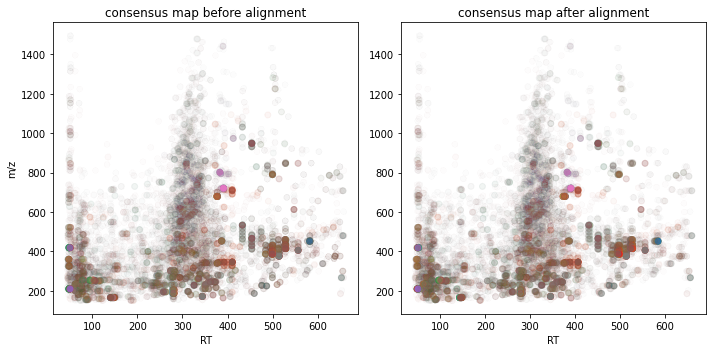

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feature_maps = [feature_maps[ref_index]] + feature_maps[:ref_index] + feature_maps[ref_index+1:]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('consensus map before alignment')
ax.set_ylabel('m/z')
ax.set_xlabel('RT')

# use alpha value to display feature intensity
ax.scatter([f.getRT() for f in feature_maps[0]], [f.getMZ() for f in feature_maps[0]],
            alpha = np.asarray([f.getIntensity() for f in feature_maps[0]])/max([f.getIntensity() for f in feature_maps[0]]))

for fm in feature_maps[1:]:
    ax.scatter([f.getMetaValue('original_RT') for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

ax = fig.add_subplot(1,2,2)
ax.set_title('consensus map after alignment')
ax.set_xlabel('RT')

for fm in feature_maps:
    ax.scatter([f.getRT() for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

fig.tight_layout()
#fig.legend([fmap.getDataProcessing()[0].getMetaValue('parameter: out')[:-11] for fmap in feature_maps], loc = 'lower center')
fig.show()

#### `8) IDMapper` 

Introduce the features to a protein identification file (idXML)- the only way to annotate MS2 spectra for GNPS FBMN  (of later importance)

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/TOPP_IDMapper.html

Import aligned feature files and load them to a FeatureMap() file

In [ ]:
input_feature_files = sorted(glob.glob("results/interim/preprocess/MapAligned*.featureXML"))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

In [ ]:
use_centroid_rt= False
use_centroid_mz= True
protein_ids = []
peptide_ids= []

mapper = IDMapper()

input_mzml_files= sorted(glob.glob("results/interim/mzML/PCfeature_*.mzML"))

for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)

    for fmap in feature_maps:
        peptide_ids = []
        protein_ids = []
        if os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[7:] == os.path.basename(filename)[10:]:
            mapper.annotate(fmap, peptide_ids, protein_ids, use_centroid_rt, use_centroid_mz, exp)
            featureidx_file = os.path.join(path, 'IDMapper_' + os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
            FeatureXMLFile().store(featureidx_file, fmap)

5470 spectra and 1 chromatograms stored.
5236 spectra and 1 chromatograms stored.
5572 spectra and 1 chromatograms stored.
5587 spectra and 1 chromatograms stored.
5471 spectra and 1 chromatograms stored.
4857 spectra and 1 chromatograms stored.
5610 spectra and 1 chromatograms stored.
5547 spectra and 1 chromatograms stored.
5402 spectra and 1 chromatograms stored.
5682 spectra and 1 chromatograms stored.
5591 spectra and 1 chromatograms stored.
5476 spectra and 1 chromatograms stored.
Unassigned peptides: 0
Peptides assigned to exactly one feature: 0
Peptides assigned to multiple features: 0
Unassigned and unidentified precursors: 4880
Unidentified precursor assigned to exactly one feature: 0
Unidentified precursor assigned to multiple features: 0
Feature annotation with identifications:
    no ID: 1049
    single ID: 0
    multiple IDs (identical): 0
    multiple IDs (divergent): 0


Unassigned peptides: 0
Peptides assigned to exactly one feature: 0
Peptides assigned to multiple fea

#### `9) FeatureGroupingAlgorithmKD `

Feature linker aggregates the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

Import the annotated feature files and load them in a FeatureMap() file

In [ ]:
input_feature_files = sorted(glob.glob('results/interim/preprocess/IDMapper*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

In [ ]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)


Consensus_file= os.path.join(path, 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)


# get intensities as a DataFrame
result = consensus_map.get_df()
result= result.reset_index()
result= result.drop(columns= ["id", "sequence", "quality"])
# store as tsv file
result.to_csv('results/features/FeatureMatrix.tsv', sep = '\t', index = False)
result

Progress of 'computing RT transformations':
-- done [took 0.24 s (CPU), 0.25 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.35 s (CPU), 0.37 s (Wall)] -- 
ConsensusXMLFile::store():  found 9106 invalid unique ids


,charge,RT,mz,20211009_UMETAB222_POS_31_ISP2_Plate-13_NBC_01134_rep3.mzML,20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.mzML,20211009_UMETAB222_POS_10_ISP2_Plate-13_NBC_01116_rep1.mzML,20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.mzML,20211009_UMETAB222_POS_11_DNPM_Plate-13_NBC_01116_rep1.mzML,20211009_UMETAB222_POS_33_FPY12_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_23_DNPM_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_32_DNPM_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_22_ISP2_Plate-13_NBC_01116_rep2.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20211009_UMETAB222_POS_24_FPY12_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_12_FPY12_Plate-13_NBC_01116_rep1.mzML
0,1,473.889839,228.195786,6456007.0,7.158484e+06,6276594.0,1.347532e+07,6472127.0,8.223848e+06,6877668.0,7490720.0,6254406.0,5396077.0,8604468.0,7479438.0
1,1,637.163227,388.263562,1488465.0,6.821783e+05,1297476.0,4.669828e+05,1449316.0,1.727871e+06,1948491.0,1692647.0,1599266.0,1901299.0,1967858.0,0.0
2,1,78.812706,185.092057,9785494.0,6.814153e+06,11802700.0,9.691823e+06,20620940.0,1.585855e+06,19825910.0,18193690.0,5129649.0,8052714.0,3993600.0,0.0
3,1,100.212525,195.112804,10770410.0,5.361819e+06,12812270.0,7.435392e+06,26797860.0,3.385145e+06,28316300.0,25457100.0,7030839.0,3564171.0,4120325.0,0.0
4,1,634.989413,376.263502,11390910.0,5.051651e+06,11274350.0,3.930575e+06,12148810.0,1.334391e+07,15677730.0,14372010.0,12087870.0,16889030.0,16178760.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,1,506.663781,506.274841,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.075308e+06,0.0,0.0,0.0,0.0,0.0,0.0
9101,1,353.058673,638.830580,0.0,0.000000e+00,0.0,0.000000e+00,0.0,3.117134e+06,0.0,0.0,0.0,0.0,0.0,0.0
9102,2,331.770704,768.359788,0.0,0.000000e+00,0.0,0.000000e+00,0.0,9.423708e+05,0.0,0.0,0.0,0.0,0.0,0.0
9103,2,343.182237,846.423576,0.0,0.000000e+00,0.0,0.000000e+00,0.0,6.449337e+05,0.0,0.0,0.0,0.0,0.0,0.0
